# Canonical MPS forms

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Functions for conversion to canonical forms

In [2]:
def local_orthonormalize_left(A, Anext):
    """
    Left-orthonormalize a MPS tensor `A` by a QR decomposition,
    and update tensor at next site.
    """
    # perform QR decomposition and replace A by reshaped Q matrix
    s = A.shape
    assert len(s) == 3
    Q, R = np.linalg.qr(np.reshape(A, (s[0]*s[1], s[2])), mode='reduced')
    A = np.reshape(Q, (s[0], s[1], Q.shape[1]))
    # update Anext tensor: multiply with R from left
    Anext = np.transpose(np.tensordot(R, Anext, (1, 1)), (1, 0, 2))
    return A, Anext

In [3]:
def mps_orthonormalize_left(Alist):
    """
    Left-orthonormalize a MPS using QR decompositions.
    The list of tensors in `Alist` are updated in-place.

    Returns the overall norm of the original MPS. (The updated MPS has norm 1.)
    """
    for i in range(len(Alist) - 1):
        Alist[i], Alist[i+1] = local_orthonormalize_left(Alist[i], Alist[i+1])
    # last tensor
    Alist[-1], T = local_orthonormalize_left(Alist[-1], np.array([[[1.0]]]))
    # normalization factor (real-valued since diagonal of R matrix is real)
    assert T.shape == (1, 1, 1)
    nrm = T[0, 0, 0].real
    if nrm < 0:
        # flip sign such that normalization factor is always non-negative
        Alist[-1] = -Alist[-1]
        nrm = -nrm
    return nrm

In [4]:
def local_orthonormalize_right(A, Aprev):
    """
    Right-orthonormalize a MPS tensor `A` by a QR decomposition,
    and update tensor at previous site.
    """
    # flip left and right virtual bond dimensions
    A = np.transpose(A, (0, 2, 1))
    # perform QR decomposition and replace A by reshaped Q matrix
    s = A.shape
    assert len(s) == 3
    Q, R = np.linalg.qr(np.reshape(A, (s[0]*s[1], s[2])))
    A = np.transpose(np.reshape(Q, (s[0], s[1], Q.shape[1])), (0, 2, 1))
    # update Aprev tensor: multiply with R from right
    Aprev = np.tensordot(Aprev, R, (2, 1))
    return A, Aprev

In [5]:
def mps_orthonormalize_right(Alist):
    """
    Right-orthonormalize a MPS using QR decompositions.
    The list of tensors in `Alist` are updated in-place.

    Returns the overall norm of the original MPS. (The updated MPS has norm 1.)
    """
    for i in reversed(range(1, len(Alist))):
        Alist[i], Alist[i-1] = local_orthonormalize_right(Alist[i], Alist[i-1])
    # first tensor
    Alist[0], T = local_orthonormalize_right(Alist[0], np.array([[[1.0]]]))
    # normalization factor (real-valued since diagonal of R matrix is real)
    assert T.shape == (1, 1, 1)
    nrm = T[0, 0, 0].real
    if nrm < 0:
        # flip sign such that normalization factor is always non-negative
        Alist[0] = -Alist[0]
        nrm = -nrm
    return nrm

In [6]:
def mps_orthonormalize_center(Alist, j):
    """
    Convert a MPS to site-canonical form with center at site `j`, such that
    all tensors to the left are left-orthonormal, and
    all tensors to the right are right-orthonormal.
    The list of tensors in `Alist` are updated in-place.
    """
    assert 0 <= j < len(Alist)
    for i in range(j):
        Alist[i], Alist[i+1] = local_orthonormalize_left(Alist[i], Alist[i+1])
    for i in reversed(range(j+1, len(Alist))):
        Alist[i], Alist[i-1] = local_orthonormalize_right(Alist[i], Alist[i-1])

In [7]:
def mps_orthonormalize_bond(Alist, j):
    """
    Convert a MPS to bond-canonical form, with a list of "singular values"
    between the `j`-th and `j+1`-th tensor.
    The list of tensors in `Alist` are updated in-place.

    Returns the singular value list.
    """
    mps_orthonormalize_center(Alist, j)
    # now we only need to update the j-th and (j+1)-th tensor
    s = Alist[j].shape
    U, S, Vh = np.linalg.svd(np.reshape(Alist[j], (s[0]*s[1], s[2])), full_matrices=False)
    Alist[j] = np.reshape(U, (s[0], s[1], U.shape[1]))
    if j < len(Alist)-1:
        # update Alist[j+1] tensor: multiply with Vh from left
        Alist[j+1] = np.transpose(np.tensordot(Vh, Alist[j+1], (1, 1)), (1, 0, 2))
    return S

## Utility functions

In [8]:
def is_left_orthonormal(A):
    """
    Test whether a MPS tensor `A` is left-orthonormal.
    """
    s = A.shape
    assert len(s) == 3
    A = np.reshape(A, (s[0]*s[1], s[2]))
    return np.allclose(A.conj().T @ A, np.identity(s[2]))

In [9]:
def is_right_orthonormal(A):
    """
    Test whether a MPS tensor `A` is right-orthonormal.
    """
    # call `is_left_orthonormal` with flipped left and right virtual bond dimensions
    return is_left_orthonormal(np.transpose(A, (0, 2, 1)))

In [10]:
def mps_to_full_tensor(Alist):
    """
    Construct the full tensor corresponding to the MPS tensors `Alist`.

    The i-th MPS tensor Alist[i] is expected to have dimensions (n[i], D[i], D[i+1]),
    with `n` the list of logical dimensions and `D` the list of virtual bond dimensions.

    Note: Should only be used for debugging and testing.
    """
    # consistency check: dummy singleton dimension
    assert Alist[0].ndim == 3 and Alist[0].shape[1] == 1
    # formally remove dummy singleton dimension
    T = np.reshape(Alist[0], (Alist[0].shape[0], Alist[0].shape[2]))
    # contract virtual bonds
    for i in range(1, len(Alist)):
        T = np.tensordot(T, Alist[i], axes=(-1, 1))
    # consistency check: trailing dummy singleton dimension
    assert T.shape[-1] == 1
    # formally remove trailing singleton dimension
    T = np.reshape(T, T.shape[:-1])
    return T

In [11]:
def mps_bond_to_full_tensor(Alist, S, j):
    """
    Construct the full tensor corresponding to the bond-canonical MPS
    with tensors `Alist` and "bond" singular values `S` between
    the `j`-th and `j+1`-th tensor.
    """
    # absorb bond singular values into j-th tensor
    Blist = [np.tensordot(Alist[i], np.diag(S), (2, 1)) if i==j else Alist[i] for i in range(len(Alist))]
    return mps_to_full_tensor(Blist)

In [12]:
def partial_trace(rho, dimA, dimB):
    """
    Compute the partial traces of a density matrix 'rho' of a composite quantum system AB.

    Args:
        rho:  density matrix of dimension dimA*dimB x dimA*dimB
        dimA: dimension of subsystem A
        dimB: dimension of subsystem B
    Returns:
        tuple: reduced density matrices for subsystems A and B
    """
    # explicit subsystem dimensions
    rho = np.reshape(rho, (dimA, dimB, dimA, dimB))
    # trace out subsystem B
    rhoA = np.trace(rho, axis1=1, axis2=3)
    # trace out subsystem A
    rhoB = np.trace(rho, axis1=0, axis2=2)
    return rhoA, rhoB

In [13]:
def crandn(size):
    """
    Draw random samples from the standard complex normal (Gaussian) distribution.
    """
    # 1/sqrt(2) is a normalization factor
    return (np.random.normal(size=size) + 1j*np.random.normal(size=size)) / np.sqrt(2)

In [14]:
def xlogx(x):
    """
    Compute `x * log(x)` (pointwise), such that the result is zero for `x = 0`.
    """
    y = np.zeros_like(x)
    idx = x > 0
    y[idx] = x[idx] * np.log(x[idx])
    return y

## Examples and tests

In [15]:
# logical and virtual bond dimensions (rather arbitrarily chosen)
n = [2, 5, 3, 4, 6, 3]
D = [1, 3, 4, 7, 6, 5, 1]

In [16]:
# random MPS tensors (the scaling factor keeps the norm of the full tensor in a reasonable range)
np.random.seed(142)
Aref = [0.3 * crandn((n[i], D[i], D[i+1])) for i in range(len(n))]

# the tensors are randomly chosen, and in particular not of any normal form
print([is_left_orthonormal(A) for A in Aref])
print([is_right_orthonormal(A) for A in Aref])

# construct the full (dense) tensor which this MPS represents, as reference (should only be constructed for testing and debugging)
Tref = mps_to_full_tensor(Aref)
# its shape must be equal to `n` from above:
print("Tref.shape:", Tref.shape)

[False, False, False, False, False, False]
[False, False, False, False, False, False]
Tref.shape: (2, 5, 3, 4, 6, 3)


### Left-orthonormalization

In [17]:
# first make a copy of the input tensors
AL = [A.copy() for A in Aref]

# function returns norm of input MPS
nrmL = mps_orthonormalize_left(AL)

In [18]:
# these should all be True
[is_left_orthonormal(A) for A in AL]

[True, True, True, True, True, True]

In [19]:
nrmL

1.2965535991355328

In [20]:
# compare norm with reference
abs(nrmL - np.linalg.norm(np.reshape(Tref, -1))) / abs(nrmL)

0.0

In [21]:
# compare full tensor with reference: difference should be zero (up to numerical rounding errors)
np.linalg.norm(nrmL*mps_to_full_tensor(AL) - Tref)

8.644849870488704e-16

### Right-orthonormalization

In [22]:
# first make a copy of the input tensors
AR = [A.copy() for A in Aref]

# function returns norm of input MPS
nrmR = mps_orthonormalize_right(AR)

In [23]:
# these should all be True
[is_right_orthonormal(A) for A in AR]

[True, True, True, True, True, True]

In [24]:
nrmR

1.2965535991355326

In [25]:
# compare norm with reference
abs(nrmR - np.linalg.norm(np.reshape(Tref, -1))) / abs(nrmR)

1.7125755932734126e-16

In [26]:
# compare full tensor with reference: difference should be zero (up to numerical rounding errors)
np.linalg.norm(nrmR*mps_to_full_tensor(AR) - Tref)

1.0218155152157865e-15

### Site-canonical form

In [27]:
# again make a copy first
AC = [A.copy() for A in Aref]

# tensors are updated in-place, and overall norm is preserved (function has no formal return value)
jcenter = 2
mps_orthonormalize_center(AC, jcenter)

In [28]:
# these should all be True
[is_left_orthonormal(A) for A in AC[:jcenter]]

[True, True]

In [29]:
# these should all be True
[is_right_orthonormal(A) for A in AC[jcenter+1:]]

[True, True, True]

In [30]:
# "center" tensor is not orthonormal in general
is_left_orthonormal(AC[jcenter]) or is_right_orthonormal(AC[jcenter])

False

In [31]:
# compare full tensor with reference: difference should be zero (up to numerical rounding errors)
np.linalg.norm(mps_to_full_tensor(AC) - Tref)

9.779738873997546e-16

### Bond-canonical form

In [32]:
# again make a copy first
AB = [A.copy() for A in Aref]

jbond = 3
S = mps_orthonormalize_bond(AB, jbond)

In [33]:
# list of singular values for "cut" at `jbond`
S

array([0.85731111, 0.65318151, 0.47655434, 0.39473114, 0.27652958,
       0.24502551])

In [34]:
# these should all be True
[is_left_orthonormal(AB[j]) if j <= jbond else is_right_orthonormal(AB[j]) for j in range(len(AB))]

[True, True, True, True, True, True]

In [35]:
# compare full tensor with reference: difference should be zero (up to numerical rounding errors)
np.linalg.norm(mps_bond_to_full_tensor(AB, S, jbond) - Tref)

2.1736105253689997e-15

### Bond-singular values and entanglement entropy

In [36]:
# compute (reduced) density matrices, as reference
ρref = np.outer(Tref, Tref.conj())
ρA, ρB = partial_trace(ρref, np.prod(n[:jbond+1]), np.prod(n[jbond+1:]))
print("ρA.shape:", ρA.shape)
print("ρB.shape:", ρB.shape)

ρA.shape: (120, 120)
ρB.shape: (18, 18)


In [37]:
# must be Hermitian
np.linalg.norm(ρA - ρA.conj().T)

0.0

In [38]:
# must be Hermitian
np.linalg.norm(ρB - ρB.conj().T)

0.0

In [39]:
λA = np.linalg.eigvalsh(ρA)
λB = np.linalg.eigvalsh(ρB)

In [40]:
# most of them are actually zero
λA

array([-1.54182361e-16, -1.30730518e-16, -9.83541762e-17, -4.64791110e-17,
       -3.88797472e-17, -3.04037437e-17, -2.82138796e-17, -2.50696642e-17,
       -2.38757875e-17, -2.30254038e-17, -2.00888655e-17, -1.88031413e-17,
       -1.75596766e-17, -1.65973383e-17, -1.59106542e-17, -1.49152889e-17,
       -1.38888153e-17, -1.27755832e-17, -1.21294079e-17, -1.18671423e-17,
       -1.14319814e-17, -1.10698936e-17, -1.03759605e-17, -1.00599632e-17,
       -9.59198363e-18, -8.97965856e-18, -8.84764308e-18, -8.04376706e-18,
       -7.67470863e-18, -7.06007447e-18, -6.92889582e-18, -6.44172905e-18,
       -6.02444840e-18, -5.87725788e-18, -5.51037840e-18, -5.10092616e-18,
       -4.96695783e-18, -4.69319368e-18, -4.48153842e-18, -4.10138385e-18,
       -3.76912983e-18, -3.33861790e-18, -3.09683876e-18, -2.99047651e-18,
       -2.64129052e-18, -2.51032500e-18, -2.18550132e-18, -1.95568645e-18,
       -1.78537791e-18, -1.57843143e-18, -1.31866528e-18, -1.27989976e-18,
       -1.14203019e-18, -

In [41]:
# filter out zero eigenvalues
λA = λA[np.logical_not(np.isclose(λA, 0, atol=1e-13))]
λB = λB[np.logical_not(np.isclose(λB, 0, atol=1e-13))]

# sort in descending order
λA = np.sort(λA)[::-1]
λB = np.sort(λB)[::-1]

In [42]:
λA

array([0.73498233, 0.42664608, 0.22710404, 0.15581267, 0.07646861,
       0.0600375 ])

In [43]:
# compare: should agree
np.linalg.norm(λA - λB)

3.835896867111847e-16

In [44]:
# compare: should agree with bond-singular values from above
np.linalg.norm(λA - S**2)

6.828731857268665e-16

In [45]:
# normalize singular values
Snrm = S / np.linalg.norm(S)
Snrm

array([0.66122303, 0.50378288, 0.36755468, 0.30444645, 0.21328048,
       0.18898217])

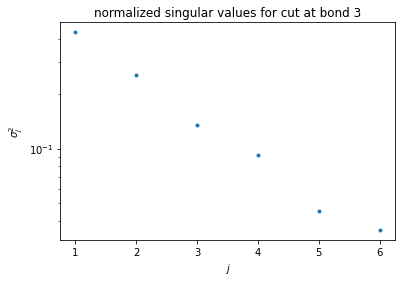

In [46]:
plt.semilogy(range(1, len(Snrm) + 1), Snrm**2, '.')
plt.ylabel("$\\sigma_j^2$")
plt.xlabel("$j$")
plt.title("normalized singular values for cut at bond {}".format(jbond))
plt.show()

In [47]:
# finally compute entanglement entropy
np.sum(-xlogx(Snrm**2))

1.460203986361991